# Running `ws3` and `libcbm` as a two-stage sequential pipeline (using built-in functions)

We run `ws3` and `libcbm` in a two-stage sequential software pipeline, using the CBM linkage functions in `ws3`. See notebook `ws3_libcbm_sequential-fromscratch` for a more detailed discussion of these linkages.

## Set up modelling environment

First, make sure we have the correct versions of `ws3` and `libcbm` installed. Both of these packages are relatively new and under active development, it is best we stick to known-working versions of each package from their respective GitHub repos. 


> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 

In [1]:
%load_ext autoreload
%autoreload 

Optionally, uninstall the `ws3` package and replace it with a pointer to _this local clone of the GitHub repository code_ (useful if you want ot tweak the source code for whatever reason). 

In [2]:
clobber_ws3 = True
if clobber_ws3:
    %pip uninstall -y ws3
    %pip install -e ..

Found existing installation: ws3 1.0.0
Uninstalling ws3-1.0.0:
  Successfully uninstalled ws3-1.0.0
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///home/gep/projects/ws3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ws3 (pyproject.toml) ... done
  Created wheel for ws3: filename=ws3-1.0.0-py2.py3-none-any.whl size=1736 sha256=1f1860ee50db5aaaad66016eaaea54446e29e9452c32e0a64dbda36603634601
  Stored in directory: /tmp/pip-ephem-wheel-cache-zcetni1o/wheels/8a/d1/f0/2b533a60b366fa03a12ca91a1ad068761e66b9df68fa0cadb9
Successfully built ws3
Note: you may need to restart the kernel to use updated packages.


Create a `ForestModel` instance by loading Woodstock-formatted input files.

In [3]:
import ws3.forest

In [4]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [5]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

Schedule some harvesting in our `ws3.ForestModel` instance using the self-parametrising priority queue heuristic defined in the local `util` module (just so we have something interesting to push through `libcbm`).

In [6]:
from util import schedule_harvest_areacontrol

In [7]:
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 3 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>], dtype=object))

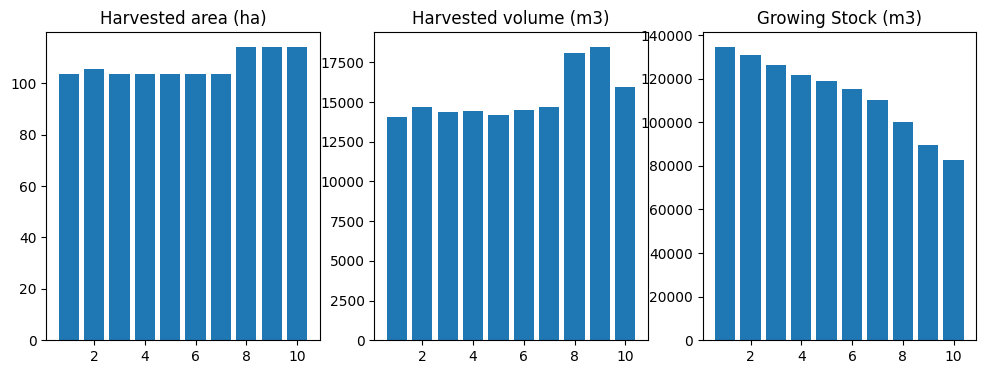

In [8]:
from util import compile_scenario, plot_scenario
df = compile_scenario(fm)
plot_scenario(df)

All of the stuff above is just to set up a working `ws3` model environment. The actual linkage with `libcbm` happens below and is quite simple.

## Hard-link `ForestModel` to `libcbm`

Next, we use `ws3` built-in CBM linkage functions to compile a `sit_config` object (a JSON-like dict namespace) and a `sit_tables` object (a dict of `pandas.DataFrame` objects) the SIT-compatible format expected by `libcbm.input.sit.sit_cbm_factory`. 

Before calling the `ForestModel.to_cbm_sit` method, we need to compile `disturbance_type_mapping` (a list of dict objects of mapping the action codes in our `ws3` model to one of the standard disturbance types defined in the CBM database) and also add a `last_pass_disturbance` attribute to each developement type in our `ws3` model (else will default to `fire`, which would still run but might make the DOM spin-up in CBM a bit wonky). 

In [9]:
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [10]:
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [11]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

In [12]:
from util import run_cbm

/home/gep/projects/ws3/.venv/lib/python3.12/site-packages/libcbm/resources/__init__.py:112: RuntimeWarning: untested linux distribution: Linux-6.8.0-48-generic-x86_64-with-glibc2.39
  warnings.warn(message, RuntimeWarning)


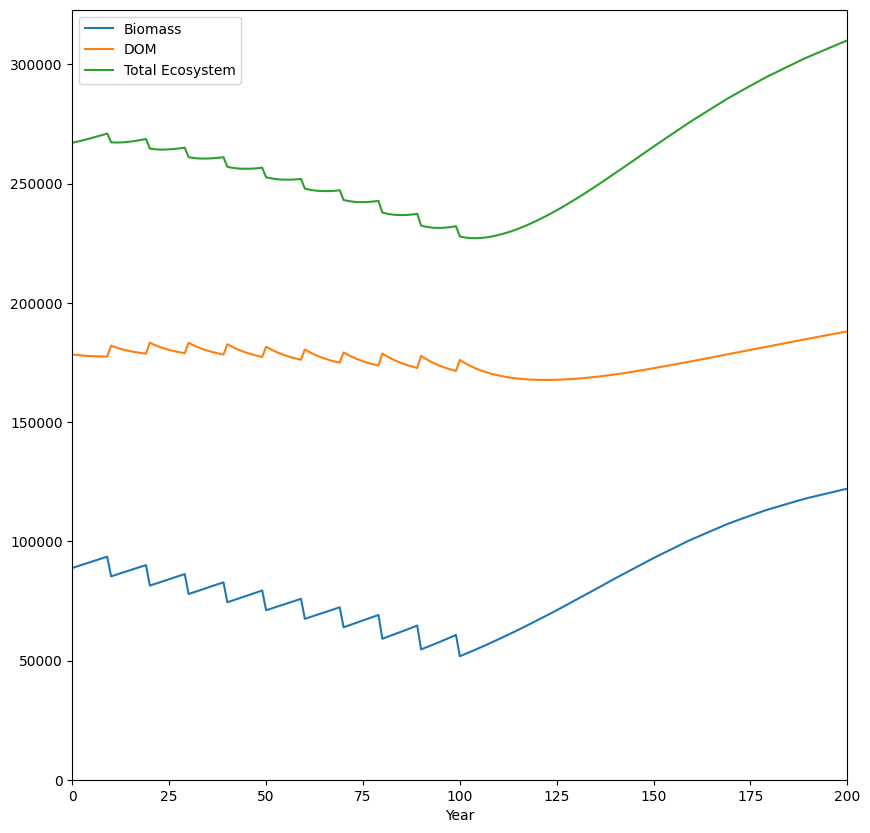

In [13]:
#n_steps = fm.horizon * fm.period_length
n_steps = 200
cbm_output = run_cbm(sit_config, sit_tables, n_steps)